# Importing Google Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Pipelining and Preprocessing

Note: Train with other type of data also

In [1]:
from tensorflow.keras.preprocessing import image

import numpy as np
import tensorflow as tf

from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import os
import time

from matplotlib import pyplot as plt
from IPython import display
from tqdm import tqdm

Using Dataset_2 as the main training data for results

In [2]:
PATH = '/content/drive/My Drive/COVID-19_Project/Classification_of_Medical_Images/Final_Dataset_Augmented_and_mirror_all_new/'

In [3]:
IMG_WIDTH = 299
IMG_HEIGHT = 299

In [4]:
data_dir_list = os.listdir(PATH)
data_dir_list

['Covid-19', 'Normal', 'Pneumonia']

In [5]:
img_data_list = []
image_path_list = []

In [6]:
for dataset in data_dir_list:
    img_list = os.listdir(PATH+dataset+'/')
    print('Loading the images of dataset - '+ '{}\n'.format(dataset))
    count = 0
    for img in tqdm(img_list):
        img_path = PATH+dataset+'/'+img
        image_path_list.append(img_path)
        img = image.load_img(img_path, target_size=(IMG_WIDTH,IMG_HEIGHT))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        img_data_list.append(x)
        count = count+1
        if count == 600:
          # otherwise make 700-700 divisions
          break

  2%|▎         | 25/1000 [00:00<00:03, 247.43it/s]

Loading the images of dataset - Covid-19



  3%|▎         | 28/1000 [00:00<00:03, 276.63it/s]

Loading the images of dataset - Normal



  3%|▎         | 27/1000 [00:00<00:03, 264.26it/s]

Loading the images of dataset - Pneumonia



 59%|█████▉    | 589/1000 [00:02<00:01, 267.37it/s]


In [7]:
img_data = np.array(img_data_list)
img_data = np.rollaxis(img_data,1,0)
img_data = img_data[0]
img_data = img_data.astype('int32')
img_data = np.abs(img_data)
print(img_data.shape)

(1800, 299, 299, 3)


In [8]:
len(image_path_list)

1800

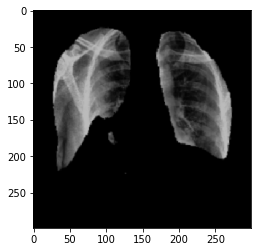

In [9]:
plt.imshow(img_data[500])

In [10]:
img_data.dtype

dtype('int32')

# Neural Network Training

Note: use other networks also

## Data Preprocessing 

In [11]:
num_classes = 3
num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples), dtype = 'int32')

In [12]:
labels[:800] = 0
labels[800:1600] = 1
labels[1600:] = 2

names = ['Covid-19', 'Normal', 'Pneumonia']

In [13]:
labels.shape

(2400,)

In [14]:
Y = np_utils.to_categorical(labels, num_classes)

x,y = shuffle(img_data,Y, random_state=2)

#X_model, X_test,Y_model, Y_test = train_test_split(x, y, test_size = 0.1, random_state = 2)

X_train_NN, X_test_NN, y_train_NN, y_test_NN = train_test_split(x, y, test_size = 0.2, random_state = 2)

In [15]:
X_test_NN.shape

(480, 299, 299, 3)

In [16]:
X_train_NN.shape

(1920, 299, 299, 3)

In [17]:
y_train_NN.shape

(1920, 3)

## Training

90

In [18]:
import tensorflow as tf
# shape 299, 299, 3

In [19]:
InceptionResNetV2 = tf.keras.applications.InceptionResNetV2(
    include_top=True, weights='imagenet', input_tensor=None, input_shape=None,
    pooling=None, classes=1000
)

In [25]:
InceptionResNetV2.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________

In [26]:
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.models import Model
last_layer = InceptionResNetV2.get_layer('avg_pool').output
x = Dense(1024, activation='relu', name='fc1')(last_layer)
x = Dense(512, activation='relu', name='fc2')(x)
x = Dense(256, activation='relu', name='fc3')(x)
out = Dense(num_classes, activation = 'softmax', name = 'output')(x)
custom_model = Model(InceptionResNetV2.input, out)

In [27]:
for layer in custom_model.layers[:-4]:
    layer.trainable = False

In [28]:
opt = tf.keras.optimizers.Adam(
    learning_rate=0.001
)

In [29]:
custom_model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

In [30]:
custom_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [31]:
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
X_train_pp = preprocess_input(X_train_NN)
X_test_pp = preprocess_input(X_test_NN)
#X_test = preprocess_input(X_test)

In [32]:
callbacks = [
    #tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
    #tf.keras.callbacks.TensorBoard(log_dir='logs\{}'.format(NAME)),
    tf.keras.callbacks.ModelCheckpoint('InceptionResNetV2.h5', save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau()]

In [33]:
custom_model.fit(X_train_pp, y_train_NN, batch_size=32, epochs=100, verbose=1, validation_data = (X_test_pp, y_test_NN), callbacks = callbacks)

Epoch 1/100
53/53 [==============================] - 26s 483ms/step - loss: 0.7105 - accuracy: 0.6976 - val_loss: 0.3247 - val_accuracy: 0.8643
Epoch 2/100
53/53 [==============================] - 22s 410ms/step - loss: 0.3086 - accuracy: 0.8869 - val_loss: 0.2442 - val_accuracy: 0.9119
Epoch 3/100
53/53 [==============================] - 21s 387ms/step - loss: 0.2477 - accuracy: 0.9006 - val_loss: 0.3915 - val_accuracy: 0.8310
Epoch 4/100
53/53 [==============================] - 23s 437ms/step - loss: 0.2029 - accuracy: 0.9208 - val_loss: 0.1523 - val_accuracy: 0.9381
Epoch 5/100
53/53 [==============================] - 21s 394ms/step - loss: 0.1569 - accuracy: 0.9482 - val_loss: 0.1657 - val_accuracy: 0.9381
Epoch 6/100
53/53 [==============================] - 22s 421ms/step - loss: 0.1604 - accuracy: 0.9399 - val_loss: 0.1393 - val_accuracy: 0.9452
Epoch 7/100
53/53 [==============================] - 21s 391ms/step - loss: 0.1859 - accuracy: 0.9220 - val_loss: 0.2513 - val_accuracy:

In [34]:
classifier = tf.keras.models.load_model("InceptionResNetV2.h5")

In [35]:
from sklearn.metrics import confusion_matrix,classification_report
y_pred = classifier.predict(X_test_pp)
y_p = np.argmax(y_pred,axis=1)
y_true = np.argmax(y_test_NN,axis=1)
print('confusion matrix')
print(confusion_matrix(y_true,y_p))

confusion matrix
[[141   1   0]
 [  0 152   3]
 [  0   2 121]]


In [36]:
print('Classification report')
print(classification_report(y_true,y_p))

Classification report
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       142
           1       0.98      0.98      0.98       155
           2       0.98      0.98      0.98       123

    accuracy                           0.99       420
   macro avg       0.99      0.99      0.99       420
weighted avg       0.99      0.99      0.99       420



###Testing the model with ML techniques

In [20]:
classifier = tf.keras.models.load_model("InceptionResNetV2.h5")

In [21]:
from tensorflow.keras.models import Model

op_layer = classifier.get_layer('fc3').output
Model_new = Model(inputs = classifier.input , outputs = op_layer)

In [22]:
Model_new.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [23]:
x_new,y_new = shuffle(img_data,labels, random_state=2)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(x_new, y_new, test_size = 0.1, random_state = 2)

In [24]:
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
X_train_1 = preprocess_input(X_train_1)
X_test_1 = preprocess_input(X_test_1)

In [25]:
y_train_1.shape

(1080,)

In [26]:
train_new = Model_new.predict(X_train_1)
test_new = Model_new.predict(X_test_1)
print(test_new)

[[0.         0.         0.21000624 ... 0.         0.         2.292322  ]
 [1.3820858  0.         1.4276743  ... 0.         0.         0.        ]
 [0.36766624 0.         0.59261024 ... 0.08822565 0.         0.        ]
 ...
 [0.         0.         0.18534783 ... 0.         0.         2.3909762 ]
 [0.9229069  0.         1.0187905  ... 0.         0.         0.        ]
 [1.7660657  0.         1.9680815  ... 0.         0.         0.        ]]


In [27]:
test_new.shape

(120, 256)

#### svm

94 and 90

In [28]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', max_iter = 50000)

svm.fit(train_new,y_train_1)
print('fitting done !!!')
svm.score(train_new,y_train_1)

fitting done !!!


0.9981481481481481

fc3

In [29]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = svm.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[41  0  0]
 [ 0 43  0]
 [ 0  1 35]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        41
           1       0.98      1.00      0.99        43
           2       1.00      0.97      0.99        36

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120



#### xg_boost

92 and 91

In [30]:
import xgboost as xgb

xb = xgb.XGBClassifier(max_iter = 50000)

xb.fit(train_new,y_train_1)

print('fitting done !!!')

xb.score(train_new,y_train_1)

fitting done !!!


1.0

fc3

In [31]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = xb.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[41  0  0]
 [ 0 43  0]
 [ 0  1 35]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        41
           1       0.98      1.00      0.99        43
           2       1.00      0.97      0.99        36

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120



#### random forest

93 and 90

In [32]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=2000)
rf.fit(train_new,y_train_1)

print('fitting done !!!')

rf.score(train_new,y_train_1)

fitting done !!!


1.0

fc3

In [33]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = rf.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[41  0  0]
 [ 0 43  0]
 [ 0  1 35]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        41
           1       0.98      1.00      0.99        43
           2       1.00      0.97      0.99        36

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120



# Descriptors Extraction and Training

## Preprocessing the Data

In [11]:
! pip install opencv-python==3.4.2.16
! pip install opencv-contrib-python==3.4.2.16

Using: SIFT

In [12]:
import cv2

In [13]:
sift = cv2.xfeatures2d.SIFT_create()
des_list = []

In [14]:
for i in tqdm(range(len(img_data))):
  img = img_data[i].copy()
  img = np.uint8(img)
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  kpts, des = sift.detectAndCompute(img, None)
  des_list.append((i, des))

100%|██████████| 1800/1800 [01:05<00:00, 27.40it/s]


In [15]:
image = cv2.drawKeypoints(image=img, outImage=img, keypoints=kpts, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

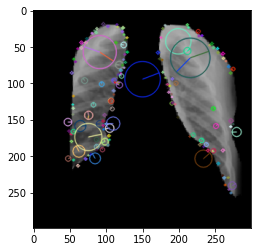

In [16]:
plt.imshow(image)
plt.show()

Using BRISK

In [11]:
import cv2

In [12]:
brisk = cv2.BRISK_create(50)
des_list = []

In [13]:
for i in tqdm(range(len(img_data))):
  img = img_data[i].copy()
  img = np.uint8(img)
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  kpts, des = brisk.detectAndCompute(img, None)
  des_list.append((i, des))

100%|██████████| 1800/1800 [00:12<00:00, 147.06it/s]


In [14]:
image = cv2.drawKeypoints(image=img, outImage=img, keypoints=kpts, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

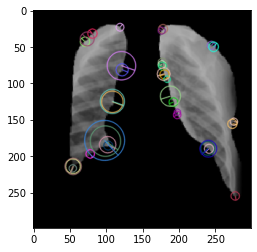

In [15]:
plt.imshow(image)
plt.show()

stacking all the descriptors vertically in a numpy array

In [16]:
descriptors = des_list[0][1]
for img_no, descriptor in tqdm(des_list[:]):
  try:
    descriptors = np.vstack((descriptors, descriptor))
  except:
    continue

100%|██████████| 1800/1800 [00:02<00:00, 675.39it/s]


In [17]:
descriptors_float = descriptors.astype(float)

Clustring using k means

Note: use others methods also

In [18]:
from scipy.cluster.vq import kmeans, vq
# we can change the value of k (no of clusters) to see the different accuracies
k = 128
voc, variance = kmeans(descriptors_float, k, 1)

calculating the histogram of the features and representing them as vectors.

vq(vector quantization) Assigns codes from a code book to observations.

In [19]:
im_features = np.zeros((len(img_data), k), "float32")
for i in tqdm(range(len(img_data))):
  try:
    words, distance = vq(des_list[i][1],voc)
    for w in words:
      im_features[i][w] += 1
  except:
    continue 

100%|██████████| 1800/1800 [00:02<00:00, 767.64it/s]


performing Tf-Idf vectorization

In [20]:
nbr_occurances = np.sum((im_features > 0) * 1, axis = 0)
idf = np.array(np.log((1.0*len(img_data) + 1) / (1.0*nbr_occurances + 1)), "float32")

Scaling the words

Standardize features by removing the mean and scaling to unit variance

In a way normalizarion

In [21]:
from sklearn.preprocessing import StandardScaler
stdSlr = StandardScaler().fit(im_features)
im_features = stdSlr.transform(im_features)

In [22]:
im_features.shape

(1800, 128)

In [23]:
im_features.dtype

dtype('float32')

In [24]:
im_features

array([[ 5.3344131e-01, -1.6389666e-01, -8.9520735e-01, ...,
        -6.7622662e-01,  1.7400455e-01,  1.1481966e-01],
       [ 2.0050032e+00, -1.6389666e-01, -1.7904148e-01, ...,
         6.7098749e-01,  4.4881673e+00, -7.8769290e-01],
       [-2.0233980e-01, -9.0328014e-01,  5.3712440e-01, ...,
        -6.7622662e-01, -6.8882799e-01,  1.1481966e-01],
       ...,
       [-2.0233980e-01, -1.6389666e-01, -8.9520735e-01, ...,
        -6.7622662e-01,  1.7400455e-01, -7.8769290e-01],
       [-9.3812084e-01, -1.6389666e-01, -8.9520735e-01, ...,
        -2.6195832e-03, -6.8882799e-01, -7.8769290e-01],
       [-9.3812084e-01, -9.0328014e-01, -8.9520735e-01, ...,
        -6.7622662e-01, -6.8882799e-01, -7.8769290e-01]], dtype=float32)

## Train and Test spliting 

In [25]:
num_classes = 3
num_of_samples = im_features.shape[0]
labels = np.ones((num_of_samples), dtype = 'int32')

labels[:600] = 0
labels[600:1200] = 1
labels[1200:] = 2

names = ['Covid-19', 'Normal', 'Pneumonia']

In [26]:
x,y = shuffle(im_features,labels, random_state=2)

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(x, y, test_size = 0.15, random_state = 2)

In [27]:
X_train_d.shape

(1530, 128)

In [28]:
y_train_d.shape

(1530,)

## Training with SIFT

### Training on SVM

In [31]:
from sklearn.svm import SVC
svm = SVC(max_iter = 50000)
svm.fit(X_train_d, y_train_d)
print('fitting done !!!')

fitting done !!!


In [32]:
svm.score(X_train_d,y_train_d)

0.9424836601307189

In [33]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = svm.predict(X_test_d)
y_true = y_test_d
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[83  2  5]
 [ 2 75  9]
 [ 7 11 76]]
              precision    recall  f1-score   support

           0       0.90      0.92      0.91        90
           1       0.85      0.87      0.86        86
           2       0.84      0.81      0.83        94

    accuracy                           0.87       270
   macro avg       0.87      0.87      0.87       270
weighted avg       0.87      0.87      0.87       270



### Training on XG_boost

In [34]:
import xgboost as xgb

xb = xgb.XGBClassifier(max_iter = 50000)

xb.fit(X_train_d,y_train_d)

print('fitting done !!!')

fitting done !!!


In [35]:
xb.score(X_train_d,y_train_d)

0.9588235294117647

In [36]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = xb.predict(X_test_d)
y_true = y_test_d
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[83  2  5]
 [ 4 74  8]
 [ 7 11 76]]
              precision    recall  f1-score   support

           0       0.88      0.92      0.90        90
           1       0.85      0.86      0.86        86
           2       0.85      0.81      0.83        94

    accuracy                           0.86       270
   macro avg       0.86      0.86      0.86       270
weighted avg       0.86      0.86      0.86       270



### Training on Random Forest

In [37]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=1000)
rf.fit(X_train_d,y_train_d)

print('fitting done !!!')

fitting done !!!


In [38]:
rf.score(X_train_d,y_train_d)

1.0

In [39]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = rf.predict(X_test_d)
y_true = y_test_d
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[77  5  8]
 [ 2 76  8]
 [ 5 14 75]]
              precision    recall  f1-score   support

           0       0.92      0.86      0.89        90
           1       0.80      0.88      0.84        86
           2       0.82      0.80      0.81        94

    accuracy                           0.84       270
   macro avg       0.85      0.85      0.85       270
weighted avg       0.85      0.84      0.84       270



## Training with BRISK

### Training on SVM

In [29]:
from sklearn.svm import SVC
svm = SVC(max_iter = 50000)
svm.fit(X_train_d, y_train_d)
print('fitting done !!!')

fitting done !!!


In [30]:
svm.score(X_train_d,y_train_d)

0.8915032679738563

In [31]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = svm.predict(X_test_d)
y_true = y_test_d
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[73  3 14]
 [ 4 68 14]
 [ 7 22 65]]
              precision    recall  f1-score   support

           0       0.87      0.81      0.84        90
           1       0.73      0.79      0.76        86
           2       0.70      0.69      0.70        94

    accuracy                           0.76       270
   macro avg       0.77      0.76      0.76       270
weighted avg       0.77      0.76      0.76       270



### Training on XG_boost

In [32]:
import xgboost as xgb

xb = xgb.XGBClassifier(max_iter = 50000)

xb.fit(X_train_d,y_train_d)

print('fitting done !!!')

fitting done !!!


In [33]:
xb.score(X_train_d,y_train_d)

0.8980392156862745

In [34]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = xb.predict(X_test_d)
y_true = y_test_d
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[70  8 12]
 [ 3 69 14]
 [ 6 28 60]]
              precision    recall  f1-score   support

           0       0.89      0.78      0.83        90
           1       0.66      0.80      0.72        86
           2       0.70      0.64      0.67        94

    accuracy                           0.74       270
   macro avg       0.75      0.74      0.74       270
weighted avg       0.75      0.74      0.74       270



### Training on Random Forest

In [35]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=1000)
rf.fit(X_train_d,y_train_d)

print('fitting done !!!')

fitting done !!!


In [36]:
rf.score(X_train_d,y_train_d)

1.0

In [37]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = rf.predict(X_test_d)
y_true = y_test_d
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[73  5 12]
 [ 2 68 16]
 [ 5 26 63]]
              precision    recall  f1-score   support

           0       0.91      0.81      0.86        90
           1       0.69      0.79      0.74        86
           2       0.69      0.67      0.68        94

    accuracy                           0.76       270
   macro avg       0.76      0.76      0.76       270
weighted avg       0.76      0.76      0.76       270



# Combining all the Processes

In [38]:
import tensorflow as tf

In [39]:
Model_s = tf.keras.models.load_model("InceptionResNetV2.h5")

In [40]:
from tensorflow.keras.models import Model

op_layer = Model_s.get_layer('fc3').output
Model_C = Model(inputs = Model_s.input , outputs = op_layer)

In [41]:
Model_C.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [42]:
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
img_data = preprocess_input(img_data)

In [43]:
Pred_fc3 = Model_C.predict(img_data)

In [44]:
Pred_fc3.shape

(1800, 256)

In [45]:
Pred_fc3.dtype

dtype('float32')

In [46]:
type(Pred_fc3)

numpy.ndarray

also using the extracted features using opencv

In [47]:
im_features.shape

(1800, 128)

In [48]:
im_features.dtype

dtype('float32')

In [49]:
type(im_features)

numpy.ndarray

combining the data from pred_fc3 and im_features

In [50]:
total_features = 384

In [51]:
total_dataset = 1800

In [52]:
feature_data = np.zeros((total_dataset, total_features), dtype = 'float32')

In [53]:
feature_data.shape

(1800, 384)

In [54]:
for i in tqdm(range(len(feature_data))):
  cv_feature = im_features[i]
  model_feature = Pred_fc3[i]
  feature_data[i] = np.concatenate((cv_feature,model_feature))

100%|██████████| 1800/1800 [00:00<00:00, 165390.54it/s]


In [55]:
feature_data

array([[ 0.5334413 , -0.16389666, -0.89520735, ...,  0.        ,
         0.        ,  3.8262565 ],
       [ 2.0050032 , -0.16389666, -0.17904148, ...,  0.        ,
         0.        ,  4.5974064 ],
       [-0.2023398 , -0.90328014,  0.5371244 , ...,  0.        ,
         0.        ,  2.863445  ],
       ...,
       [-0.2023398 , -0.16389666, -0.89520735, ...,  0.        ,
         0.        ,  0.        ],
       [-0.93812084, -0.16389666, -0.89520735, ...,  0.        ,
         0.        ,  0.        ],
       [-0.93812084, -0.90328014, -0.89520735, ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

Train Test split

change accordance to the type of training

In [56]:
num_classes = 3
num_of_samples = feature_data.shape[0]
labels = np.ones((num_of_samples), dtype = 'int32')

labels[:600] = 0
labels[600:1200] = 1
labels[1200:] = 2

names = ['Covid-19', 'Normal', 'Pneumonia']

Use Different Train Test Splitting --> 0.05, 0.1, 0.2, 0.3

In [57]:
# use the following line training the Deep learning Model
Y = np_utils.to_categorical(labels, num_classes)

x,y = shuffle(feature_data,Y, random_state=2)

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(x, y, test_size = 0.2, random_state = 2)

In [58]:
X_train_c.shape

(1440, 384)

In [59]:
y_train_c.shape

(1440, 3)

## Training DL model

In [60]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [61]:
model_combined = Sequential()
model_combined.add(Dense(1024, input_dim=384, activation='relu', name='dense_1'))
model_combined.add(Dense(800, activation='relu', name='dense_2'))
model_combined.add(Dense(512, activation='relu', name='dense_3'))
model_combined.add(Dense(300, activation='relu', name='dense_4'))
model_combined.add(Dense(256, activation='relu', name='dense_5'))
model_combined.add(Dense(128, activation='relu', name='dense_6'))
model_combined.add(Dense(3, activation='softmax', name = 'output_layer'))

In [62]:
opt = tf.keras.optimizers.Adam(
    learning_rate=0.001
)

In [63]:
model_combined.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

make wider, make deeper, make wider and deeper, and also use other methods

In [64]:
model_combined.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              394240    
_________________________________________________________________
dense_2 (Dense)              (None, 800)               820000    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               410112    
_________________________________________________________________
dense_4 (Dense)              (None, 300)               153900    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               77056     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
output_layer (Dense)         (None, 3)                 3

In [65]:
callbacks = [
    #tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
    #tf.keras.callbacks.TensorBoard(log_dir='logs\{}'.format(NAME)),
    tf.keras.callbacks.ModelCheckpoint('InceptionResNetV2_combined_BRISK.h5', save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau()]

In [66]:
model_combined.fit(X_train_c, y_train_c, batch_size=32, epochs=100, verbose=1, validation_data = (X_test_c, y_test_c), callbacks = callbacks)

Epoch 1/100
45/45 [==============================] - 0s 9ms/step - loss: 0.1253 - accuracy: 0.9715 - val_loss: 0.0051 - val_accuracy: 0.9972
Epoch 2/100
45/45 [==============================] - 0s 5ms/step - loss: 0.0344 - accuracy: 0.9931 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 3/100
45/45 [==============================] - 1s 15ms/step - loss: 0.0095 - accuracy: 0.9958 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 4/100
45/45 [==============================] - 0s 4ms/step - loss: 0.0081 - accuracy: 0.9986 - val_loss: 0.0233 - val_accuracy: 0.9944
Epoch 5/100
45/45 [==============================] - 0s 4ms/step - loss: 0.0024 - accuracy: 0.9993 - val_loss: 0.0103 - val_accuracy: 0.9972
Epoch 6/100
45/45 [==============================] - 0s 5ms/step - loss: 0.0061 - accuracy: 0.9993 - val_loss: 6.5737e-05 - val_accuracy: 1.0000
Epoch 7/100
45/45 [==============================] - 0s 4ms/step - loss: 0.0097 - accuracy: 0.9972 - val_loss: 6.6858e-04 - val_accuracy: 1.0000
Epoc

In [71]:
Model_n = tf.keras.models.load_model("InceptionResNetV2_combined_BRISK.h5")

In [72]:
from sklearn.metrics import confusion_matrix,classification_report
y_pred = Model_n.predict(X_test_c)
y_p = np.argmax(y_pred,axis=1)
y_true = np.argmax(y_test_c,axis=1)
print('confusion matrix')
print(confusion_matrix(y_true,y_p))

confusion matrix
[[122   0   0]
 [  0 115   0]
 [  0   0 123]]


In [73]:
print('Classification report')
print(classification_report(y_true,y_p))

Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       122
           1       1.00      1.00      1.00       115
           2       1.00      1.00      1.00       123

    accuracy                           1.00       360
   macro avg       1.00      1.00      1.00       360
weighted avg       1.00      1.00      1.00       360



SIFT ACCURACY was 100%

## Using ML methods

In [74]:
Model_n = tf.keras.models.load_model("InceptionResNetV2_combined_BRISK.h5")

In [75]:
from tensorflow.keras.models import Model

op_layer = Model_n.get_layer('dense_6').output
Model_csn = Model(inputs = Model_n.input , outputs = op_layer)

In [76]:
Model_csn.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1_input (InputLayer)   [(None, 384)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              394240    
_________________________________________________________________
dense_2 (Dense)              (None, 800)               820000    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               410112    
_________________________________________________________________
dense_4 (Dense)              (None, 300)               153900    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               77056     
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

In [77]:
x_new,y_new = shuffle(feature_data,labels, random_state=2)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(x_new, y_new, test_size = 0.2, random_state = 2)

In [78]:
train_new = Model_csn.predict(X_train_1)
test_new = Model_csn.predict(X_test_1)
print(test_new)

[[ 0.         0.         0.        ...  5.659002   0.         0.       ]
 [ 0.         6.359362  50.546936  ...  0.         0.        44.021015 ]
 [ 0.         0.         0.        ... 12.196163   0.         0.       ]
 ...
 [ 0.        13.764366   0.        ...  0.         5.8769517  0.       ]
 [ 0.        14.33438    0.        ...  0.         6.1187735  0.       ]
 [ 0.         7.7404957 61.2743    ...  0.         0.        53.2705   ]]


###Results With SIFT - Scale Invarient Feature Transform

#### SVM

In [78]:
from sklearn.svm import SVC
svm = SVC(max_iter = 50000)
svm.fit(train_new, y_train_1)
print('fitting done !!!')

fitting done !!!


In [79]:
svm.score(train_new, y_train_1)

1.0

In [80]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = svm.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[122   0   0]
 [  0 115   0]
 [  0   0 123]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       122
           1       1.00      1.00      1.00       115
           2       1.00      1.00      1.00       123

    accuracy                           1.00       360
   macro avg       1.00      1.00      1.00       360
weighted avg       1.00      1.00      1.00       360



#### xg_boost

In [81]:
import xgboost as xgb

xb = xgb.XGBClassifier(max_iter = 50000)

xb.fit(train_new,y_train_1)

print('fitting done !!!')

fitting done !!!


In [82]:
xb.score(train_new,y_train_1)

1.0

In [83]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = xb.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[122   0   0]
 [  0 115   0]
 [  0   0 123]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       122
           1       1.00      1.00      1.00       115
           2       1.00      1.00      1.00       123

    accuracy                           1.00       360
   macro avg       1.00      1.00      1.00       360
weighted avg       1.00      1.00      1.00       360



#### Random forest

In [84]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=1000)
rf.fit(train_new,y_train_1)

print('fitting done !!!')

fitting done !!!


In [85]:
rf.score(train_new,y_train_1)

1.0

In [86]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = rf.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[122   0   0]
 [  0 115   0]
 [  0   0 123]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       122
           1       1.00      1.00      1.00       115
           2       1.00      1.00      1.00       123

    accuracy                           1.00       360
   macro avg       1.00      1.00      1.00       360
weighted avg       1.00      1.00      1.00       360



###Results With BRISK - Binary Robust Invarient Scalable Keypoints

#### SVM

In [79]:
from sklearn.svm import SVC
svm = SVC(max_iter = 50000)
svm.fit(train_new, y_train_1)
print('fitting done !!!')

fitting done !!!


In [80]:
svm.score(train_new, y_train_1)

0.9986111111111111

In [81]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = svm.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[122   0   0]
 [  0 115   0]
 [  0   0 123]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       122
           1       1.00      1.00      1.00       115
           2       1.00      1.00      1.00       123

    accuracy                           1.00       360
   macro avg       1.00      1.00      1.00       360
weighted avg       1.00      1.00      1.00       360



#### xg_boost

In [82]:
import xgboost as xgb

xb = xgb.XGBClassifier(max_iter = 50000)

xb.fit(train_new,y_train_1)

print('fitting done !!!')

fitting done !!!


In [83]:
xb.score(train_new,y_train_1)

1.0

In [84]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = xb.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[122   0   0]
 [  0 115   0]
 [  0   0 123]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       122
           1       1.00      1.00      1.00       115
           2       1.00      1.00      1.00       123

    accuracy                           1.00       360
   macro avg       1.00      1.00      1.00       360
weighted avg       1.00      1.00      1.00       360



#### Random forest

In [85]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=1000)
rf.fit(train_new,y_train_1)

print('fitting done !!!')

fitting done !!!


In [86]:
rf.score(train_new,y_train_1)

1.0

In [87]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = rf.predict(test_new)
y_true = y_test_1
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[122   0   0]
 [  0 115   0]
 [  0   0 123]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       122
           1       1.00      1.00      1.00       115
           2       1.00      1.00      1.00       123

    accuracy                           1.00       360
   macro avg       1.00      1.00      1.00       360
weighted avg       1.00      1.00      1.00       360



# Testing the models

## Dataset Preprocessing

In [88]:
from tensorflow.keras.preprocessing import image

import numpy as np

from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import os
import time

from matplotlib import pyplot as plt
from IPython import display
from tqdm import tqdm
import tensorflow as tf


In [89]:
PATH = '/content/drive/My Drive/COVID-19_Project/Classification_of_Medical_Images/Testing_Dataset/'

In [90]:
IMG_WIDTH = 299
IMG_HEIGHT = 299

In [91]:
data_dir_list = os.listdir(PATH)
data_dir_list

['Covid-19', 'Normal', 'Pneumonia']

In [92]:
img_data_list = []
image_path_list = []

In [93]:
for dataset in data_dir_list:
    img_list = os.listdir(PATH+dataset+'/')
    print('Loading the images of dataset - '+ '{}\n'.format(dataset))
    count = 0
    for img in tqdm(img_list):
        img_path = PATH+dataset+'/'+img
        image_path_list.append(img_path)
        img = image.load_img(img_path, target_size=(IMG_WIDTH,IMG_HEIGHT))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        img_data_list.append(x)
        count = count+1
        if count == 800:
          # otherwise make 700-700 divisions
          break

 38%|███▊      | 35/91 [00:00<00:00, 344.37it/s]

Loading the images of dataset - Covid-19



 35%|███▌      | 32/91 [00:00<00:00, 317.16it/s]

Loading the images of dataset - Normal



 37%|███▋      | 36/97 [00:00<00:00, 353.84it/s]

Loading the images of dataset - Pneumonia



100%|██████████| 97/97 [00:00<00:00, 339.86it/s]


In [94]:
img_data = np.array(img_data_list)
img_data = np.rollaxis(img_data,1,0)
img_data = img_data[0]
img_data = img_data.astype('int32')
img_data = np.abs(img_data)
print(img_data.shape)

(279, 299, 299, 3)


In [95]:
len(image_path_list)

279

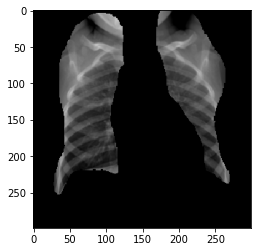

In [96]:
plt.imshow(img_data[100])

In [97]:
img_data.dtype

dtype('int32')

In [98]:
num_classes = 3
num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples), dtype = 'int32')

In [99]:
labels[:91] = 0
labels[91:182] = 1
labels[182:] = 2

names = ['Covid-19', 'Normal', 'Pneumonia']

In [100]:
labels.shape

(279,)

In [101]:
Y = np_utils.to_categorical(labels, num_classes)

X_test,Y_test = shuffle(img_data,Y, random_state=2)

## Simple Model

In [48]:
Model_n = tf.keras.models.load_model("InceptionResNetV2.h5")

In [49]:
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
X_test = preprocess_input(X_test)

In [50]:
from sklearn.metrics import confusion_matrix,classification_report
y_pred = Model_n.predict(X_test)
y_p = np.argmax(y_pred,axis=1)
y_true = np.argmax(Y_test,axis=1)
print('confusion matrix')
print(confusion_matrix(y_true,y_p))

confusion matrix
[[85  0  6]
 [ 1 76 14]
 [ 1 10 86]]


In [51]:
print('Classification report')
print(classification_report(y_true,y_p))

Classification report
              precision    recall  f1-score   support

           0       0.98      0.93      0.96        91
           1       0.88      0.84      0.86        91
           2       0.81      0.89      0.85        97

    accuracy                           0.89       279
   macro avg       0.89      0.89      0.89       279
weighted avg       0.89      0.89      0.89       279



ML Techniques

In [52]:
classifier = tf.keras.models.load_model("InceptionResNetV2.h5")

In [53]:
from tensorflow.keras.models import Model

op_layer = classifier.get_layer('fc3').output
Model_new = Model(inputs = classifier.input , outputs = op_layer)

In [54]:
x_test_new,y_test_new = shuffle(img_data,labels, random_state=2)

In [55]:
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
x_test_new = preprocess_input(x_test_new)

In [56]:
test_new_x = Model_new.predict(x_test_new)

svm

In [57]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = svm.predict(test_new_x)
y_true = y_test_new
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[87  0  4]
 [ 1 76 14]
 [ 2  9 86]]
              precision    recall  f1-score   support

           0       0.97      0.96      0.96        91
           1       0.89      0.84      0.86        91
           2       0.83      0.89      0.86        97

    accuracy                           0.89       279
   macro avg       0.90      0.89      0.89       279
weighted avg       0.89      0.89      0.89       279



xg_boost

In [58]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = xb.predict(test_new_x)
y_true = y_test_new
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[85  0  6]
 [ 1 76 14]
 [ 1  8 88]]
              precision    recall  f1-score   support

           0       0.98      0.93      0.96        91
           1       0.90      0.84      0.87        91
           2       0.81      0.91      0.86        97

    accuracy                           0.89       279
   macro avg       0.90      0.89      0.89       279
weighted avg       0.90      0.89      0.89       279



random_forest

In [59]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = rf.predict(test_new_x)
y_true = y_test_new
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[87  0  4]
 [ 1 77 13]
 [ 1 10 86]]
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        91
           1       0.89      0.85      0.87        91
           2       0.83      0.89      0.86        97

    accuracy                           0.90       279
   macro avg       0.90      0.90      0.90       279
weighted avg       0.90      0.90      0.90       279



## Feature Extraction

### SIFT

In [101]:
! pip install opencv-python==3.4.2.16
! pip install opencv-contrib-python==3.4.2.16

In [102]:
import cv2

In [103]:
sift = cv2.xfeatures2d.SIFT_create()
des_list = []

In [104]:
for i in tqdm(range(len(img_data))):
  img = img_data[i].copy()
  img = np.uint8(img)
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  kpts, des = sift.detectAndCompute(img, None)
  des_list.append((i, des))

100%|██████████| 279/279 [00:10<00:00, 26.58it/s]


In [105]:
image = cv2.drawKeypoints(image=img, outImage=img, keypoints=kpts, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

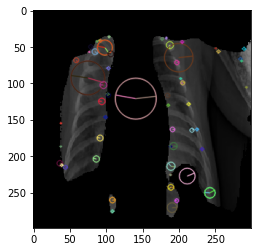

In [106]:
plt.imshow(image)
plt.show()

In [107]:
descriptors = des_list[0][1]
for img_no, descriptor in tqdm(des_list[:]):
  try:
    descriptors = np.vstack((descriptors, descriptor))
  except:
    continue

100%|██████████| 279/279 [00:01<00:00, 255.98it/s]


In [108]:
descriptors_float = descriptors.astype(float)

In [109]:
from scipy.cluster.vq import kmeans, vq
# we can change the value of k (no of clusters) to see the different accuracies
k = 128
voc, variance = kmeans(descriptors_float, k, 1)

In [110]:
im_features = np.zeros((len(img_data), k), "float32")
for i in tqdm(range(len(img_data))):
  try:
    words, distance = vq(des_list[i][1],voc)
    for w in words:
      im_features[i][w] += 1
  except:
    continue 

100%|██████████| 279/279 [00:00<00:00, 526.30it/s]


In [111]:
nbr_occurances = np.sum((im_features > 0) * 1, axis = 0)
idf = np.array(np.log((1.0*len(img_data) + 1) / (1.0*nbr_occurances + 1)), "float32")

In [112]:
from sklearn.preprocessing import StandardScaler
stdSlr = StandardScaler().fit(im_features)
im_features = stdSlr.transform(im_features)

In [113]:
im_features.shape

(279, 128)

In [114]:
im_features.dtype

dtype('float32')

In [115]:
Model_s = tf.keras.models.load_model("InceptionResNetV2.h5")

In [116]:
from tensorflow.keras.models import Model

op_layer = Model_s.get_layer('fc3').output
Model_C = Model(inputs = Model_s.input , outputs = op_layer)

In [117]:
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
img_data = preprocess_input(img_data)

In [118]:
Pred_fc3 = Model_C.predict(img_data)

In [119]:
total_features = 384
total_dataset = 279

feature_data = np.zeros((total_dataset, total_features), dtype = 'float32')

for i in tqdm(range(len(feature_data))):
  cv_feature = im_features[i]
  model_feature = Pred_fc3[i]
  feature_data[i] = np.concatenate((cv_feature,model_feature))

100%|██████████| 279/279 [00:00<00:00, 84595.59it/s]


In [120]:
feature_data.shape

(279, 384)

In [121]:
num_classes = 3
num_of_samples = feature_data.shape[0]
labels = np.ones((num_of_samples), dtype = 'int32')

labels[:91] = 0
labels[91:182] = 1
labels[182:] = 2

names = ['Covid-19', 'Normal', 'Pneumonia']

In [122]:
Y = np_utils.to_categorical(labels, num_classes)

X_test_SIFT,Y_test_SIFT = shuffle(feature_data,Y, random_state=2)

In [123]:
Model_n = tf.keras.models.load_model("InceptionResNetV2_combined_SIFT.h5")

In [124]:
from sklearn.metrics import confusion_matrix,classification_report
y_pred = Model_n.predict(X_test_SIFT)
y_p = np.argmax(y_pred,axis=1)
y_true = np.argmax(Y_test_SIFT,axis=1)
print('confusion matrix')
print(confusion_matrix(y_true,y_p))

confusion matrix
[[87  0  4]
 [ 1 76 14]
 [ 1 10 86]]


In [125]:
print('Classification report')
print(classification_report(y_true,y_p))

Classification report
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        91
           1       0.88      0.84      0.86        91
           2       0.83      0.89      0.86        97

    accuracy                           0.89       279
   macro avg       0.90      0.89      0.89       279
weighted avg       0.89      0.89      0.89       279



#### ML Techniques

In [126]:
from tensorflow.keras.models import Model

op_layer = Model_n.get_layer('dense_6').output
Model_csn = Model(inputs = Model_n.input , outputs = op_layer)

In [127]:
x_new_test,y_new_test = shuffle(feature_data,labels, random_state=2)

In [128]:
new_test_x = Model_csn.predict(x_new_test)

In [129]:
from sklearn.metrics import confusion_matrix, classification_report

svm

In [130]:
y_pred = svm.predict(new_test_x)
y_true = y_new_test
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[86  1  4]
 [ 1 76 14]
 [ 1 11 85]]
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        91
           1       0.86      0.84      0.85        91
           2       0.83      0.88      0.85        97

    accuracy                           0.89       279
   macro avg       0.89      0.89      0.89       279
weighted avg       0.89      0.89      0.89       279



xg_boost

In [131]:
y_pred = xb.predict(new_test_x)
y_true = y_new_test
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[87  0  4]
 [ 1 76 14]
 [ 1 11 85]]
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        91
           1       0.87      0.84      0.85        91
           2       0.83      0.88      0.85        97

    accuracy                           0.89       279
   macro avg       0.89      0.89      0.89       279
weighted avg       0.89      0.89      0.89       279



random forest

In [132]:
y_pred = rf.predict(new_test_x)
y_true = y_new_test
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[87  0  4]
 [ 1 76 14]
 [ 1 10 86]]
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        91
           1       0.88      0.84      0.86        91
           2       0.83      0.89      0.86        97

    accuracy                           0.89       279
   macro avg       0.90      0.89      0.89       279
weighted avg       0.89      0.89      0.89       279



### BRISK

In [102]:
import cv2

In [103]:
brisk = cv2.BRISK_create(50)
des_list = []

In [104]:
for i in tqdm(range(len(img_data))):
  img = img_data[i].copy()
  img = np.uint8(img)
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  kpts, des = brisk.detectAndCompute(img, None)
  des_list.append((i, des))

100%|██████████| 279/279 [00:01<00:00, 144.13it/s]


In [105]:
image = cv2.drawKeypoints(image=img, outImage=img, keypoints=kpts, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

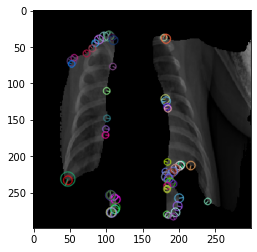

In [106]:
plt.imshow(image)
plt.show()

In [107]:
descriptors = des_list[0][1]
for img_no, descriptor in tqdm(des_list[:]):
  try:
    descriptors = np.vstack((descriptors, descriptor))
  except:
    continue

100%|██████████| 279/279 [00:00<00:00, 3427.51it/s]


In [108]:
descriptors_float = descriptors.astype(float)

In [109]:
from scipy.cluster.vq import kmeans, vq
# we can change the value of k (no of clusters) to see the different accuracies
k = 128
voc, variance = kmeans(descriptors_float, k, 1)

In [110]:
im_features = np.zeros((len(img_data), k), "float32")
for i in tqdm(range(len(img_data))):
  try:
    words, distance = vq(des_list[i][1],voc)
    for w in words:
      im_features[i][w] += 1
  except:
    continue 

100%|██████████| 279/279 [00:00<00:00, 724.03it/s]


In [111]:
nbr_occurances = np.sum((im_features > 0) * 1, axis = 0)
idf = np.array(np.log((1.0*len(img_data) + 1) / (1.0*nbr_occurances + 1)), "float32")

In [112]:
from sklearn.preprocessing import StandardScaler
stdSlr = StandardScaler().fit(im_features)
im_features = stdSlr.transform(im_features)

In [113]:
im_features.shape

(279, 128)

In [114]:
im_features.dtype

dtype('float32')

In [115]:
Model_s = tf.keras.models.load_model("InceptionResNetV2.h5")

In [116]:
from tensorflow.keras.models import Model

op_layer = Model_s.get_layer('fc3').output
Model_C = Model(inputs = Model_s.input , outputs = op_layer)

In [117]:
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
img_data = preprocess_input(img_data)

In [118]:
Pred_fc3 = Model_C.predict(img_data)

In [119]:
total_features = 384
total_dataset = 279

feature_data = np.zeros((total_dataset, total_features), dtype = 'float32')

for i in tqdm(range(len(feature_data))):
  cv_feature = im_features[i]
  model_feature = Pred_fc3[i]
  feature_data[i] = np.concatenate((cv_feature,model_feature))

100%|██████████| 279/279 [00:00<00:00, 59924.77it/s]


In [120]:
feature_data.shape

(279, 384)

In [121]:
num_classes = 3
num_of_samples = feature_data.shape[0]
labels = np.ones((num_of_samples), dtype = 'int32')

labels[:91] = 0
labels[91:182] = 1
labels[182:] = 2

names = ['Covid-19', 'Normal', 'Pneumonia']

In [122]:
Y = np_utils.to_categorical(labels, num_classes)

X_test_SIFT,Y_test_SIFT = shuffle(feature_data,Y, random_state=2)

In [123]:
Model_n = tf.keras.models.load_model("InceptionResNetV2_combined_BRISK.h5")

In [124]:
from sklearn.metrics import confusion_matrix,classification_report
y_pred = Model_n.predict(X_test_SIFT)
y_p = np.argmax(y_pred,axis=1)
y_true = np.argmax(Y_test_SIFT,axis=1)
print('confusion matrix')
print(confusion_matrix(y_true,y_p))

confusion matrix
[[87  0  4]
 [ 1 74 16]
 [ 2  9 86]]


In [125]:
print('Classification report')
print(classification_report(y_true,y_p))

Classification report
              precision    recall  f1-score   support

           0       0.97      0.96      0.96        91
           1       0.89      0.81      0.85        91
           2       0.81      0.89      0.85        97

    accuracy                           0.89       279
   macro avg       0.89      0.89      0.89       279
weighted avg       0.89      0.89      0.89       279



#### ML Techniques

In [126]:
from tensorflow.keras.models import Model

op_layer = Model_n.get_layer('dense_6').output
Model_csn = Model(inputs = Model_n.input , outputs = op_layer)

In [127]:
x_new_test,y_new_test = shuffle(feature_data,labels, random_state=2)

In [128]:
new_test_x = Model_csn.predict(x_new_test)

In [129]:
from sklearn.metrics import confusion_matrix, classification_report

svm

In [130]:
y_pred = svm.predict(new_test_x)
y_true = y_new_test
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[86  0  5]
 [ 1 74 16]
 [ 1 11 85]]
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        91
           1       0.87      0.81      0.84        91
           2       0.80      0.88      0.84        97

    accuracy                           0.88       279
   macro avg       0.88      0.88      0.88       279
weighted avg       0.88      0.88      0.88       279



xg_boost

In [131]:
y_pred = xb.predict(new_test_x)
y_true = y_new_test
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[87  0  4]
 [ 1 73 17]
 [ 2  9 86]]
              precision    recall  f1-score   support

           0       0.97      0.96      0.96        91
           1       0.89      0.80      0.84        91
           2       0.80      0.89      0.84        97

    accuracy                           0.88       279
   macro avg       0.89      0.88      0.88       279
weighted avg       0.89      0.88      0.88       279



random forest

In [132]:
y_pred = rf.predict(new_test_x)
y_true = y_new_test
print(confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred))

[[87  0  4]
 [ 1 74 16]
 [ 2 10 85]]
              precision    recall  f1-score   support

           0       0.97      0.96      0.96        91
           1       0.88      0.81      0.85        91
           2       0.81      0.88      0.84        97

    accuracy                           0.88       279
   macro avg       0.89      0.88      0.88       279
weighted avg       0.88      0.88      0.88       279

